In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

from google.cloud import bigquery
from google.oauth2 import service_account

from lets_plot import *

In [2]:
credentials = service_account.Credentials.from_service_account_file(
    'bigquery_account_credentials.json',
    scopes=['https://www.googleapis.com/auth/cloud-platform'],
)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [3]:
def load_gdf(geometry, query):
    df = client.query(query).result().to_dataframe()
    df[geometry] = df[geometry].apply(wkt.loads)
    return gpd.GeoDataFrame(df, geometry=geometry)

In [4]:
boroughs_gdf = load_gdf('borough_geom', '''
    SELECT borough_name, borough_geom
    FROM `bigquery-public-data.new_york_subway.geo_nyc_borough_boundaries`
''')

In [5]:
stations_gdf = load_gdf('station_geom', '''
    SELECT station_name, line, station_geom
    FROM `bigquery-public-data.new_york_subway.stations`
''')

In [6]:
lines_gdf = load_gdf('line_geom', '''
    SELECT ny_s.line, ST_MakeLine(ARRAY(
        SELECT station_geom
        FROM `bigquery-public-data.new_york_subway.stations`
        WHERE line = ny_s.line
        )) AS line_geom
    FROM(
        SELECT line 
        FROM `bigquery-public-data.new_york_subway.stations`
        ) AS ny_s
    GROUP BY line
''')


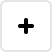
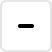
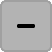
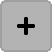
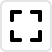
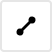
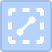

In [7]:
ggplot() + \
    geom_polygon(aes(fill='borough_name'), data=boroughs_gdf, color='black', alpha=.15) + \
    scale_fill_discrete(name='') + \
    geom_path(aes(color='line'), data=lines_gdf, size=2) + \
    scale_color_discrete(name='Line') + \
    geom_point(aes(fill='station_name'), data=stations_gdf, shape=1, size=1.5) + \
    theme(axis_title='blank', axis_text='blank', axis_ticks='blank', axis_line='blank') + \
    ggsize(1000, 800)